# Load Data

Load the data that have been preprocessed.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('datasets/df_preprocess.csv')
df

,x0_No relevent experience,x1_Part time course,x1_no_enrollment,city_0,city_1,city_2,city_3,city_4,city_5,city_6,city_7,major_discipline_0,major_discipline_1,major_discipline_2,major_discipline_3,company_size_0,company_size_1,company_size_2,company_size_3,company_type_0,company_type_1,company_type_2,company_type_3,education_level,experience,enrollee_id,city_development_index,gender,last_new_job,training_hours,target
0,0.0,0.0,1.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,2,5,8949,0.920,Male,1.0,36,1.0
1,1.0,0.0,1.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,2,3,29725,0.776,Male,5.0,47,0.0
2,1.0,0.0,0.0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,2,1,11561,0.624,Male,0.0,83,0.0
3,1.0,0.0,1.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,2,0,33241,0.789,Male,0.0,52,1.0
4,0.0,0.0,1.0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,3,5,666,0.767,Male,4.0,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,1.0,0.0,1.0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,2,3,7386,0.878,Male,1.0,42,1.0
19154,0.0,0.0,1.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,2,3,31398,0.920,Male,4.0,52,1.0
19155,0.0,0.0,1.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,2,5,24576,0.920,Male,4.0,44,0.0
19156,0.0,0.0,1.0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,5756,0.802,Male,2.0,97,0.0


In [ ]:
df.isnull().sum()

x0_No relevent experience    0
x1_Part time course          0
x1_no_enrollment             0
city_0                       0
city_1                       0
city_2                       0
city_3                       0
city_4                       0
city_5                       0
city_6                       0
city_7                       0
major_discipline_0           0
major_discipline_1           0
major_discipline_2           0
major_discipline_3           0
company_size_0               0
company_size_1               0
company_size_2               0
company_size_3               0
company_type_0               0
company_type_1               0
company_type_2               0
company_type_3               0
education_level              0
experience                   0
enrollee_id                  0
city_development_index       0
gender                       0
last_new_job                 0
training_hours               0
target                       0
dtype: int64

---------------------------
# Data Splitting

Data divided by function train_test_split from sklearn. The proportion between data training and data test is 80:20, 80% data training and 20% data test. Parameter stratify used in train_test_split to keep same proportion in the data training and data test.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df.drop(columns=['enrollee_id', 'gender', 'target'])
y = df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.2,
    random_state=0
)

------------------------
# Modeling

The model that will be used is a supervised learning model with the type of classification. This is in align with the binary targets, which is 0 and 1. Several classification models and ensemble models were collected and tested one by one in order to obtain the best base model before being given features engineering and hyperparameter tuning.

The models are:
1. SVM
2. Logistic Regression
3. Random Forest Classifier
4. Decision Tree Classifier
5. KNeighbors Classifier
6. Gradient Boosting Classifier
7. XGBoost Classifier

In [ ]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.metrics import precision_score, classification_report, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

classifiers = ['SVM', 'Logistic',  'RandomForest', 
               'KNeighbors', 'DecisionTree', 
               'GradientBoosting', 'XGBoost']

models = [svm.SVC(random_state=0),
          LogisticRegression(random_state=0),
          RandomForestClassifier(random_state=0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          GradientBoostingClassifier(random_state=0),
          XGBClassifier(random_state=0)]

In [ ]:
Score = pd.DataFrame({"Classifier":classifiers})
j = 0
precision = []
for i in models:
    model = i
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    precision.append(precision_score(y_test,predictions))
    j = j+1     

Score["Precision_Score"] = precision
Score.sort_values(by="Precision_Score", ascending=False,inplace = True)
Score.reset_index(drop=True, inplace=True)
Score

,Classifier,Precision_Score
0,XGBoost,0.597163
1,GradientBoosting,0.594595
2,Logistic,0.588083
3,RandomForest,0.516312
4,DecisionTree,0.438003
5,KNeighbors,0.387574
6,SVM,0.000000


It can be seen in the table above, the best model based on the precision score is XGBoost Classifier with a value of 0.597163.

# Model Benchmark

In the benchmark model, the model is trained and tested without any tuning, so that the model can be used as a reference for the next model to be tuned. When the tuning model is obtained, it can be tested whether the model is better than the base model or not.

In [ ]:
model_bench = XGBClassifier(random_state=0)
model_bench.fit(X_train, y_train)
y_pred_bench = model_bench.predict(X_test)

Precision_score: 0.5971631205673759


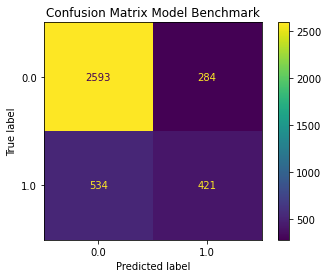

In [ ]:
print('Precision_score:', precision_score(y_test, y_pred_bench))

plot_confusion_matrix(model_bench, X_test, y_test, values_format='0.7g')
plt.title('Confusion Matrix Model Benchmark')
plt.show()

We got Precision score 0.597 and False positive 284 or 40.28%.

# Model Tuning

## Feature Selection

To simplify the data and also the model, feature selection can be done. The features in the data will be selected based on which features affect the prediction the most (Feature Importance), so that the features that will be included in the machine learning process become fewer and simpler. This can make predictions more accurate and reduce training time from the data.

In this feature selection, we use the Random Forest Classifier as a test model to get feature importance. This is based on a journal that tested the feature selection method using the Random Forest Classifier, Recrusive Feature Elimination, and Boruta. In the journal, the Random Forest Classifier outperformed other methods in terms of feature selection.

source: https://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00327-4

In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=0)
X_tr, X_te, Y_tr, Y_te = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)
rf.fit(X_tr, Y_tr)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

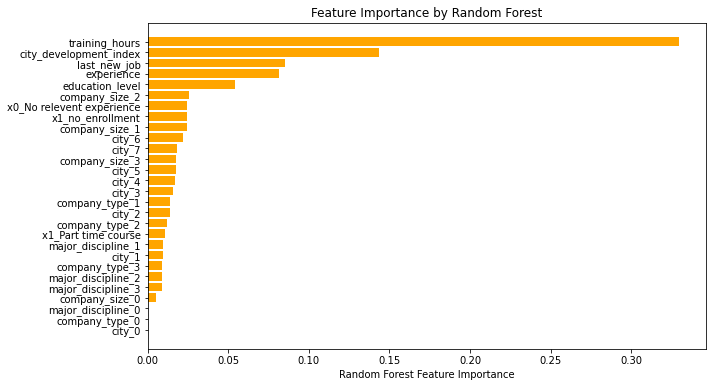

In [ ]:
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=(10,6))
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx],color = 'orange')
plt.xlabel("Random Forest Feature Importance")
plt.title('Feature Importance by Random Forest')
plt.show()

The graph above contains the features sorted by their effect on the target prediction. It can be seen that there are 5 features whose influence is quite significant compared to other features. These features are:
1. Training Hours
2. City Development Index
3. Last new job
4. Experience
5. Education level

Thus, this feature selection stage produces only 5 features that will be included in the next modeling process.

## Data Splitting

The data splitting process is the same as the previous data splitting. It's just that the features included are only 5 features, which is city development index, education level, experience, last new job, and training hours.

In [ ]:
X_select = df[['city_development_index', 'education_level', 'experience', 'last_new_job', 'training_hours']]
y_select = df['target']

In [ ]:
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_select,
    y_select,
    stratify=y_select,
    test_size=0.2,
    random_state=0
)

## Model after Feature Selection

The XGBoost model was tested again after the feature selection process that had been done previously.

In [ ]:
model_sel = XGBClassifier(random_state=0)
model_sel.fit(X_train_sel, y_train_sel)
y_pred_sel = model_sel.predict(X_test_sel)

Precision_score: 0.5925324675324676


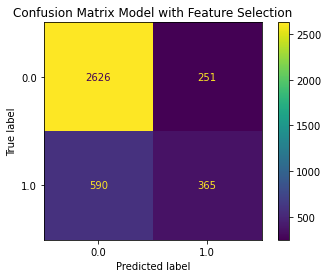

In [ ]:
print('Precision_score:', precision_score(y_test_sel, y_pred_sel))
plot_confusion_matrix(model_sel, X_test_sel, y_test_sel, values_format='0.7g')
plt.title('Confusion Matrix Model with Feature Selection')
plt.show()

After feature selection, precision score is 0.592. It's lower than model benchmark for  just 0.005. But, the False Positive are higher on 40.75%, just increasing 0.47%.

## Model after Feature Selection & SMOTETomek

Furthermore, the model will be tested again after adding resample method for imbalance class. We will use combine method of over-sampling and under sampling. This handling is important because when we are faced with data in which one of the targets dominates, the model will tend to include many entries into the category of the majority target. This is certainly not what we want to generate from the model we have created.

SMOTE showed that this method can generate noisy samples by interpolating new points between marginal outliers and inliers. This issue can be solved by cleaning the space resulting from over-sampling. In this regard, Tomek's link are the cleaning methods that have been added to the pipeline after applying SMOTE over-sampling.[1]

SMOTE+TOMEK is such a hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space. After the oversampling is done by SMOTE, the class clusters may be invading each other’s space. As a result, the classifier model will be overfitting. Now, Tomek links are the opposite class paired samples that are the closest neighbors to each other. Therefore the majority of class observations from these links are removed as it is believed to increase the class separation near the decision boundaries. Now, to get better class clusters, Tomek links are applied to oversampled minority class samples done by SMOTE. Thus instead of removing the observations only from the majority class, we generally remove both the class observations from the Tomek links.[2]

Source: <br>
[1] https://imbalanced-learn.org/stable/combine.html#combine<br>
[2] https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

smote = SMOTETomek(sampling_strategy=1/2,random_state=0)
X_sm, y_sm = smote.fit_resample(X_select, y_select)

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(
    X_sm,
    y_sm,
    stratify=y_sm,
    test_size=0.2,
    random_state=0
)

In [ ]:
model_sm = XGBClassifier(random_state=0)
model_sm.fit(X_train_sm, y_train_sm)
y_pred_sm = model_sm.predict(X_test_sm)

Precision_score: 0.7033985581874357


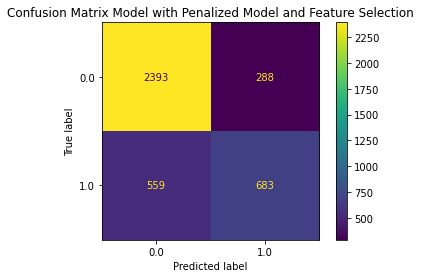

In [ ]:
print('Precision_score:', precision_score(y_test_sm, y_pred_sm))
plot_confusion_matrix(model_sm, X_test_sm, y_test_sm, values_format='0.7g')
plt.title('Confusion Matrix Model with Penalized Model and Feature Selection')
plt.show()

After feature selection and resampling, precision score is 0.7033. It's much higher than model after feature selection for 0.1109. The False Positive are lower than previous model on 29.66%, decreasing for 11,09%.

# Hyperparameter Tuning (feature selection & resampling)

The last step that can be done to improve the quality of the model is by means of hyperparameter tuning. Hyperparameter tuning is done by finding the best parameter values from the model in order to get the best model. In the XGBoost Classifier, the parameters that are usually tuned are:
1. max_depth
2. learning_rate
3. subsample
4. colsample_bytree
6. n_estimators

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [ ]:
params = {
    'max_depth':[3,6,10],
    'subsample':[0.5,0.8],
    'n_estimators':[100,500,1000],
    'colsample_bytree':[0.3,0.7],
}

skfold = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(
    estimator=model_sm,
    param_grid=params,
    cv=skfold,
    scoring='precision',
    verbose=1,
    n_jobs=-1,
)

In [ ]:
grid_search.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  7.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'max_depth': [3, 6, 10],

In [ ]:
print('Precision_score:', grid_search.best_score_)
print('Best Parameters:', grid_search.best_params_)

Precision_score: 0.7803295079670565
Best Parameters: {'colsample_bytree': 0.3, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}


In [ ]:
model_end = grid_search.best_estimator_
model_end.fit(X_train_sm, y_train_sm)
y_pred_end = model_end.predict(X_test_sm)

Precision_score: 0.7725752508361204


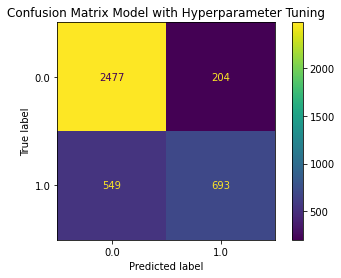

In [ ]:
print('Precision_score:', precision_score(y_test_sm, y_pred_end))
plot_confusion_matrix(model_end, X_test_sm, y_test_sm, values_format='0.7g')
plt.title('Confusion Matrix Model with Hyperparameter Tuning')
plt.show()

In [ ]:
print(classification_report(y_test_sm, y_pred_end))

              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87      2681
         1.0       0.77      0.56      0.65      1242

    accuracy                           0.81      3923
   macro avg       0.80      0.74      0.76      3923
weighted avg       0.80      0.81      0.80      3923



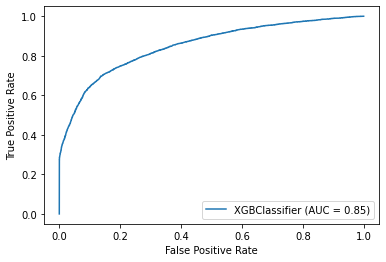

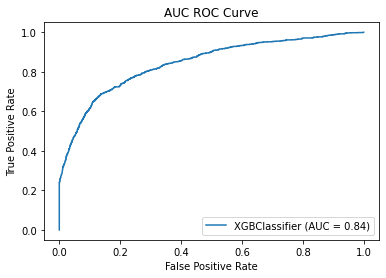

In [ ]:
plot_roc_curve(model_end, X_train_sm, y_train_sm)
plot_roc_curve(model_end, X_test_sm, y_test_sm)
plt.title('AUC ROC Curve')
plt.show()

We have tuned the model using grid search cv. We got precision score 0.7726. This means the model would predict 77.26% correctly for all of the data. To support it, we also compute the confusion matrix, classification report, and AOC & ROC Curve.

If we take a look at the confusion matrix, we got 204 False Positive and 693 True Positive. We got False Positive by 22.74%, decreased 6.92% from previous model. 

This AOC & ROC Score 0.84 are considered excellent if we quote from journal [Receiver Operating Characteristic Curve in Diagnostic Test Assessment](https://doi.org/10.1097/JTO.0b013e3181ec173d) by Jayawant N. Mandrekar, Phd:
"In general, an AUC of 0.5 suggests no discrimination (i.e., ability to diagnose patients with and without the disease or condition based on the test), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding"

# Variable Interpretation

Because we use tree as the model for machine learning, we can't interpret it easily. It's different if we use linear model because they have coefficient for each features. The coefficient could explain the weight the features have and it's importance. In tree model, we don't have that coefficient to explain tha model to the user. So, we use Shap package to explain the tree model.

### Import Package

In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
columns = ['city_development_index', 'education_level', 'experience', 'last_new_job', 'training_hours']
X_sm_df = pd.DataFrame(X_sm, columns=columns)
columns_int = ['education_level', 'experience', 'last_new_job', 'training_hours']
X_sm_df[columns_int] = X_sm_df[columns_int].astype(int)

In [ ]:
explainer = shap.TreeExplainer(grid_search.best_estimator_)
shap_values = explainer.shap_values(X_sm)

## Force Plot

The first thing we do is combine the explainer with shap values. We plot it into a figure that can expalin the degree of importance for each features.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sm_df.iloc[0,:])

We can see that there's 5 features on the graph. Three features are on the left and two features on the right. Those three feature will have to go up if we want to become less likely to change the job. Meanwhile for two on the right, they have to lower their values if we want to become less likely to change the job.

## Summary Plot

We plot the features with shap values. 

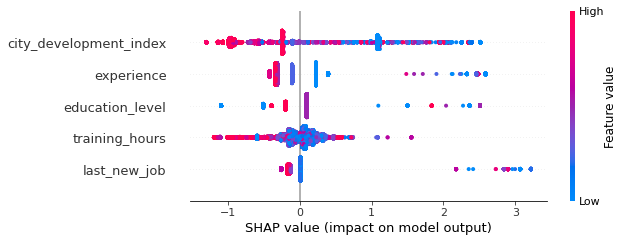

In [ ]:
shap.summary_plot(shap_values, X_sm_df)

On the horizontal axis is the SHAP value, which measures the impact of each variable on the prediction, and on the vertical axis are the dependent variables. To understand how it is interpreted, we’ll use the example of the first variable (city_development_index). We can observe that the values located to the left of the central line are red, which represents a high SHAP value. This means that candidates who live in cities with low development rates will be more likely to change jobs. Conversely, values on the right that are mostly blue (low SHAP values) will be more likely to not change jobs. Thus, we can conclude that the lower the development index of the candidates’ cities, the greater the probability that they will change jobs, and viceversa.

## Dependence Plot

It's the same with summary plot, but we'll look at the graph for each variables.

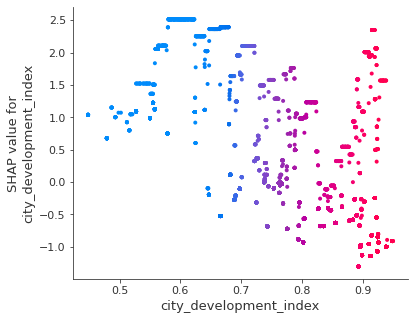

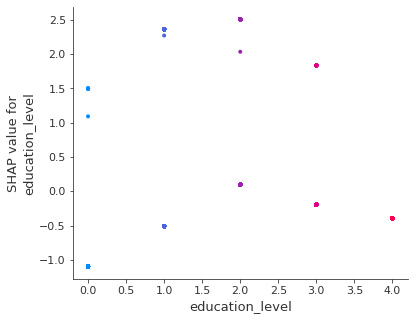

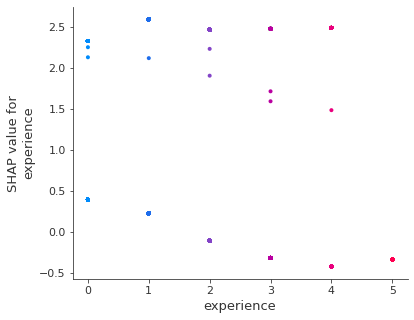

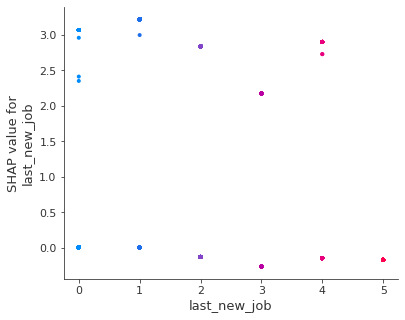

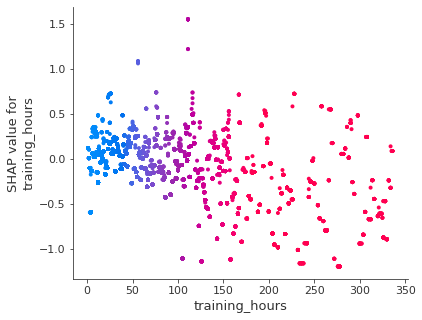

In [ ]:
for name in X_select.columns:
  shap.dependence_plot(name, shap_values, X_sm_df, display_features=X_sm_df)

The following graph complements the previous one by granting a deeper interpretation of the variables. For example, observing education_level, we can see that candidates with a lower level of education, especially those with only primary and secondary education, are less likely to change jobs. Next, the implication of each dependent variable in the prediction of the independent variable (target) is interpreted as:

* The lower the development index of the candidates’ cities (<0.70), the more likely they are to change jobs, and viceversa.
* Candidates with fewer training hours are more likely to change jobs.
* As mentioned above, candidates with primary and secondary education are less likely to change jobs.
* Candidates with fewer years of work experience are more likely to change jobs.
* Candidates who recently changed jobs and started a new job are less likely to switch again

# Impelementation

We will use aug_test.csv data to implement the model. The result will be the list of candidate that can be approached by the HR Department.

## Load Data

In [ ]:
df_test = pd.read_csv('datasets/aug_test.csv')
df_test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


## Preprocess

Before we input the data to the model, we have to clean it first and do preprocessing. We will do preprocessing the same as before we build the model.

### Cleaning

In [ ]:
df_test['experience'] = df_test['experience'].replace({'>20':21, '<1':0})
df_test['experience'] = df_test['experience'].astype(float)
df_test['experience'] = df_test['experience'].map(lambda x: 'F' if x<1 else\
                                          'E' if 1<=x<=5 else\
                                          'D' if 5<x<=10 else\
                                          'C' if 10<x<=15 else\
                                          'B' if 15<x<=20 else\
                                          'A' if x>20 else\
                                            np.nan)

df_test['last_new_job'] = df_test['last_new_job'].replace({'never':0, '1':1, '2':2, '3':3, '4':4,'>4':5})
df_test['last_new_job'] = df_test['last_new_job'].astype(float)

### Imputer

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
columns = ['gender', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']

simple_impute = SimpleImputer(strategy='most_frequent')
df_test[columns] = simple_impute.fit_transform(df_test[columns])
df_test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,D,<10,Pvt Ltd,1.0,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,E,50-99,Pvt Ltd,1.0,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,STEM,F,50-99,Pvt Ltd,0.0,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,C,10/49,Pvt Ltd,1.0,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,A,10000+,Pvt Ltd,5.0,72


In [ ]:
df_test.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64

### Encoding

In [ ]:
!pip install category_encoders

In [ ]:
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
onehot_encoding = OneHotEncoder(drop='first')
onehot_var = ['relevent_experience', 'enrolled_university']

In [ ]:
binary_encoding = ce.BinaryEncoder()
binary_var = ['city', 'major_discipline', 'company_size', 'company_type']

In [ ]:
ordinal_var = ['education_level', 'experience']
ordinal_mapping = [
    {
        'col':'education_level',
        'mapping':{
            'Primary School':0,
            'High School':1,
            'Graduate':2,
            'Masters':3,
            'Phd':4
        }
    },

    {
        'col':'experience',
        'mapping':{
            'F':0,
            'E':1,
            'D':2,
            'C':3,
            'B':4,
            'A':5
        }
    }
]

ordinal_encoder = ce.OrdinalEncoder(mapping=ordinal_mapping)

In [ ]:
transformer = ColumnTransformer(
    [
        ('one hot', onehot_encoding, onehot_var),
        ('binary', binary_encoding, binary_var),
        ('ordinal', ordinal_encoder, ordinal_var)
    ],
    remainder='passthrough'
)

In [ ]:
df_test_prep = pd.DataFrame(transformer.fit_transform(df_test))

In [ ]:
onehot_features = list(transformer.transformers_[0][1].get_feature_names())
binary_features = list(transformer.transformers_[1][1].get_feature_names())
ordinal_features = list(transformer.transformers_[2][1].get_feature_names())
features = onehot_features + binary_features + ordinal_features + ['enrollee_id', 'city_development_index', 'gender', 'last_new_job', 'training_hours']

In [ ]:
df_test_prep.columns = features

In [ ]:
df_test_prep.head()

,x0_No relevent experience,x1_Part time course,x1_no_enrollment,city_0,city_1,city_2,city_3,city_4,city_5,city_6,city_7,major_discipline_0,major_discipline_1,major_discipline_2,major_discipline_3,company_size_0,company_size_1,company_size_2,company_size_3,company_type_0,company_type_1,company_type_2,company_type_3,education_level,experience,enrollee_id,city_development_index,gender,last_new_job,training_hours
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,2,2,32403,0.827,Male,1,21
1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,2,1,9858,0.92,Female,1,98
2,1,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,31806,0.624,Male,0,15
3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,3,3,27385,0.827,Male,1,39
4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,2,5,27724,0.92,Male,5,72


## Model Implement

Finally we implement the model to get the list of candidates that can be approached by the HR.

In [ ]:
# Select the features
df_test_sel = df_test_prep[['city_development_index', 'education_level', 'experience', 'last_new_job', 'training_hours']].astype(float).to_numpy()

# Add column target using the model
df_test_prep['target'] = model_end.predict(df_test_sel)

# Filter the data as only have target==1 and select features
df_columns = ['enrollee_id', 'city_development_index', 'education_level', 'experience', 'last_new_job', 'training_hours']
candidate_list = df_test_prep[df_test_prep['target'] == 1][df_columns]

# Change data type to int
df_columns_int = ['enrollee_id','education_level', 'experience', 'last_new_job', 'training_hours']
candidate_list[df_columns_int] = candidate_list[df_columns_int].astype(int)
candidate_list

,enrollee_id,city_development_index,education_level,experience,last_new_job,training_hours
2,31806,0.624,1,0,0,15
6,21465,0.624,2,0,1,11
9,16287,0.624,2,1,1,4
18,21514,0.624,2,2,4,23
19,29033,0.624,2,1,0,110
...,...,...,...,...,...,...
2092,33290,0.624,2,2,0,36
2093,27216,0.624,2,1,0,22
2097,13464,0.624,2,0,0,86
2115,13833,0.624,2,2,1,8


We also calculate the percentage candidate listed in this data.

In [ ]:
print('Total candidate in df_test:', len(df_test_prep))
print('Total candidate listed:', len(candidate_list))
print('Candidate listed percentage: ', (len(candidate_list)/len(df_test)) * 100)

Total candidate in df_test: 2129
Total candidate listed: 316
Candidate listed percentage:  14.84264913104744


Then, we can sort the candidate using experience and training hours. Those two variables are the one that deciding the order of the candidate because it can show their ability in the data science.

In [ ]:
candidate_list.sort_values(by=['experience', 'training_hours'], ascending=False).head(10)

,enrollee_id,city_development_index,education_level,experience,last_new_job,training_hours
1841,32540,0.624,2,5,1,46
283,40,0.624,2,3,0,109
878,27338,0.624,2,3,1,103
952,33064,0.624,3,3,4,78
154,31272,0.624,2,3,4,56
667,30756,0.624,2,3,0,43
121,19567,0.624,2,3,1,42
600,19385,0.624,2,3,1,36
1761,32105,0.624,2,3,2,34
431,32487,0.624,2,3,1,25


Finaly we have 316 candidates that can be approached by the HR with enrollee_id number 32540 as the first place.